In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opendatasets

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mantasu/face-attributes-grouped")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chathui3628
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mantasu/face-attributes-grouped


100%|██████████| 1.50G/1.50G [00:11<00:00, 144MB/s] 


In [17]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from PIL import Image

In [18]:
# 1. CONFIGURATION
BASE_DIR = '/content/face-attributes-grouped/face-attributes-grouped'  # change if needed
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR   = os.path.join(BASE_DIR, 'val')
TEST_DIR  = os.path.join(BASE_DIR, 'test')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_HEAD = 15
EPOCHS_FINE = 50

# Only train 'accessories' category
CATEGORY = 'accessories'
CLASSES = ['earrings', 'necklace', 'no_accessories', 'piercings']


In [19]:
# 2. Data generators
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen_val = ImageDataGenerator(rescale=1./255)

train_gen = datagen_train.flow_from_directory(
    os.path.join(TRAIN_DIR, CATEGORY),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=True
)
val_gen = datagen_val.flow_from_directory(
    os.path.join(VAL_DIR, CATEGORY),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=False
)
test_gen = datagen_val.flow_from_directory(
    os.path.join(TEST_DIR, CATEGORY),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=False
)

Found 4000 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [20]:
# 3. Build model
def build_model(num_classes, input_shape=(224,224,3)):
    base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=out)
    return model

model = build_model(num_classes=len(CLASSES), input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))


In [21]:
# Phase 1: train head only
for layer in model.layers:
    if hasattr(layer, 'trainable'):
        layer.trainable = False
model.layers[-1].trainable = True  # only final Dense

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cb1 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(f'best_{CATEGORY}_phase1.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_HEAD,
    callbacks=cb1
)

# Phase 2: fine-tune top layers
model.load_weights(f'best_{CATEGORY}_phase1.h5')
for layer in model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cb2 = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    ModelCheckpoint(f'best_{CATEGORY}_final.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FINE,
    callbacks=cb2
)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.3584 - loss: 1.3559
Epoch 1: val_loss improved from inf to 1.05783, saving model to best_accessories_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 523ms/step - accuracy: 0.3588 - loss: 1.3553 - val_accuracy: 0.5600 - val_loss: 1.0578 - learning_rate: 0.0010
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.4946 - loss: 1.1635
Epoch 2: val_loss improved from 1.05783 to 1.00460, saving model to best_accessories_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 460ms/step - accuracy: 0.4947 - loss: 1.1633 - val_accuracy: 0.5900 - val_loss: 1.0046 - learning_rate: 0.0010
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.5350 - loss: 1.1176
Epoch 3: val_loss improved from 1.00460 to 0.97993, saving model to best_accessories_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - accuracy: 0.5349 - loss: 1.1175 - val_accuracy: 0.6050 - val_loss: 0.9799 - learning_rate: 0.0010
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.5298 - loss: 1.0952
Epoch 4: val_loss improved from 0.97993 to 0.96254, saving model to best_accessories_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - accuracy: 0.5297 - loss: 1.0953 - val_accuracy: 0.6250 - val_loss: 0.9625 - learning_rate: 0.0010
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.5609 - loss: 1.0444
Epoch 5: val_loss improved from 0.96254 to 0.93116, saving model to best_accessories_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 460ms/step - accuracy: 0.5609 - loss: 1.0446 - val_accuracy: 0.6300 - val_loss: 0.9312 - learning_rate: 0.0010
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.5518 - loss: 1.0526
Epoch 6: val_loss did not improve from 0.93116
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - accuracy: 0.5517 - loss: 1.0526 - val_accuracy: 0.6025 - val_loss: 0.9528 - learning_rate: 0.0010
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.5302 - loss: 1.0745
Epoch 7: val_loss did not improve from 0.93116
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 461ms/step - accuracy: 0.5303 - loss: 1.0743 - val_accuracy: 0.6150 - val_loss: 0.9363 - learning_rate: 0.0010
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.5468 - loss: 1.0642
Epoch 8: val_loss improved from 0.93116 to 0.91285, saving model to best_accessories_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 453ms/step - accuracy: 0.5468 - loss: 1.0641 - val_accuracy: 0.6375 - val_loss: 0.9129 - learning_rate: 0.0010
Epoch 9/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.5663 - loss: 1.0410
Epoch 9: val_loss improved from 0.91285 to 0.91009, saving model to best_accessories_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 458ms/step - accuracy: 0.5662 - loss: 1.0410 - val_accuracy: 0.6350 - val_loss: 0.9101 - learning_rate: 0.0010
Epoch 10/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.5644 - loss: 1.0500
Epoch 10: val_loss improved from 0.91009 to 0.90377, saving model to best_accessories_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 456ms/step - accuracy: 0.5644 - loss: 1.0500 - val_accuracy: 0.6375 - val_loss: 0.9038 - learning_rate: 0.0010
Epoch 11/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.5633 - loss: 1.0405
Epoch 11: val_loss improved from 0.90377 to 0.90239, saving model to best_accessories_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - accuracy: 0.5633 - loss: 1.0404 - val_accuracy: 0.6500 - val_loss: 0.9024 - learning_rate: 0.0010
Epoch 12/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.5755 - loss: 1.0237
Epoch 12: val_loss did not improve from 0.90239
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 460ms/step - accuracy: 0.5754 - loss: 1.0237 - val_accuracy: 0.6300 - val_loss: 0.9066 - learning_rate: 0.0010
Epoch 13/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.5632 - loss: 1.0401
Epoch 13: val_loss did not improve from 0.90239
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 453ms/step - accuracy: 0.5632 - loss: 1.0402 - val_accuracy: 0.6150 - val_loss: 0.9129 - learning_rate: 0.0010
Epoch 14/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.5396 - loss: 1.0515
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: val_loss did not improve from 0.90239
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 466ms/step - accuracy: 0.5397 - loss: 1.0514 -

125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - accuracy: 0.5621 - loss: 1.0255 - val_accuracy: 0.6525 - val_loss: 0.8910 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 15.
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.4862 - loss: 1.1850
Epoch 1: val_loss improved from inf to 0.84866, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 135s 659ms/step - accuracy: 0.4862 - loss: 1.1849 - val_accuracy: 0.6625 - val_loss: 0.8487 - learning_rate: 1.0000e-05
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.5614 - loss: 1.0636
Epoch 2: val_loss improved from 0.84866 to 0.82508, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 598ms/step - accuracy: 0.5615 - loss: 1.0635 - val_accuracy: 0.6675 - val_loss: 0.8251 - learning_rate: 1.0000e-05
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.6013 - loss: 0.9892
Epoch 3: val_loss improved from 0.82508 to 0.79238, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 592ms/step - accuracy: 0.6013 - loss: 0.9892 - val_accuracy: 0.6800 - val_loss: 0.7924 - learning_rate: 1.0000e-05
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.6116 - loss: 0.9448
Epoch 4: val_loss improved from 0.79238 to 0.75675, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 593ms/step - accuracy: 0.6116 - loss: 0.9447 - val_accuracy: 0.7100 - val_loss: 0.7568 - learning_rate: 1.0000e-05
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.6406 - loss: 0.8873
Epoch 5: val_loss improved from 0.75675 to 0.71629, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 596ms/step - accuracy: 0.6406 - loss: 0.8873 - val_accuracy: 0.7250 - val_loss: 0.7163 - learning_rate: 1.0000e-05
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.6526 - loss: 0.8523
Epoch 6: val_loss improved from 0.71629 to 0.68066, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 602ms/step - accuracy: 0.6527 - loss: 0.8522 - val_accuracy: 0.7225 - val_loss: 0.6807 - learning_rate: 1.0000e-05
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.6719 - loss: 0.8235
Epoch 7: val_loss improved from 0.68066 to 0.64466, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 587ms/step - accuracy: 0.6719 - loss: 0.8233 - val_accuracy: 0.7525 - val_loss: 0.6447 - learning_rate: 1.0000e-05
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.6991 - loss: 0.7271
Epoch 8: val_loss improved from 0.64466 to 0.61503, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 597ms/step - accuracy: 0.6990 - loss: 0.7273 - val_accuracy: 0.7650 - val_loss: 0.6150 - learning_rate: 1.0000e-05
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.7149 - loss: 0.7313
Epoch 9: val_loss improved from 0.61503 to 0.60478, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 599ms/step - accuracy: 0.7149 - loss: 0.7313 - val_accuracy: 0.7825 - val_loss: 0.6048 - learning_rate: 1.0000e-05
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.7163 - loss: 0.6972
Epoch 10: val_loss improved from 0.60478 to 0.58101, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 588ms/step - accuracy: 0.7164 - loss: 0.6971 - val_accuracy: 0.7800 - val_loss: 0.5810 - learning_rate: 1.0000e-05
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.7556 - loss: 0.6416
Epoch 11: val_loss improved from 0.58101 to 0.56430, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 594ms/step - accuracy: 0.7555 - loss: 0.6418 - val_accuracy: 0.7900 - val_loss: 0.5643 - learning_rate: 1.0000e-05
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.7540 - loss: 0.6356
Epoch 12: val_loss improved from 0.56430 to 0.55059, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 592ms/step - accuracy: 0.7539 - loss: 0.6356 - val_accuracy: 0.7975 - val_loss: 0.5506 - learning_rate: 1.0000e-05
Epoch 13/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.7555 - loss: 0.6012
Epoch 13: val_loss improved from 0.55059 to 0.54161, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 595ms/step - accuracy: 0.7555 - loss: 0.6012 - val_accuracy: 0.7975 - val_loss: 0.5416 - learning_rate: 1.0000e-05
Epoch 14/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.7734 - loss: 0.5702
Epoch 14: val_loss improved from 0.54161 to 0.52936, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 599ms/step - accuracy: 0.7734 - loss: 0.5702 - val_accuracy: 0.8125 - val_loss: 0.5294 - learning_rate: 1.0000e-05
Epoch 15/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7903 - loss: 0.5412
Epoch 15: val_loss improved from 0.52936 to 0.52471, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 589ms/step - accuracy: 0.7903 - loss: 0.5412 - val_accuracy: 0.8150 - val_loss: 0.5247 - learning_rate: 1.0000e-05
Epoch 16/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.7721 - loss: 0.5666
Epoch 16: val_loss improved from 0.52471 to 0.50734, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 596ms/step - accuracy: 0.7722 - loss: 0.5664 - val_accuracy: 0.8250 - val_loss: 0.5073 - learning_rate: 1.0000e-05
Epoch 17/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.7968 - loss: 0.5373
Epoch 17: val_loss improved from 0.50734 to 0.50302, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 591ms/step - accuracy: 0.7968 - loss: 0.5372 - val_accuracy: 0.8250 - val_loss: 0.5030 - learning_rate: 1.0000e-05
Epoch 18/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.8136 - loss: 0.5025
Epoch 18: val_loss improved from 0.50302 to 0.49885, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 590ms/step - accuracy: 0.8136 - loss: 0.5025 - val_accuracy: 0.8375 - val_loss: 0.4988 - learning_rate: 1.0000e-05
Epoch 19/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.8178 - loss: 0.4625
Epoch 19: val_loss did not improve from 0.49885
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 587ms/step - accuracy: 0.8178 - loss: 0.4626 - val_accuracy: 0.8250 - val_loss: 0.5053 - learning_rate: 1.0000e-05
Epoch 20/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.8186 - loss: 0.4589
Epoch 20: val_loss improved from 0.49885 to 0.48757, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 598ms/step - accuracy: 0.8186 - loss: 0.4589 - val_accuracy: 0.8400 - val_loss: 0.4876 - learning_rate: 1.0000e-05
Epoch 21/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.8226 - loss: 0.4405
Epoch 21: val_loss improved from 0.48757 to 0.48670, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 587ms/step - accuracy: 0.8226 - loss: 0.4405 - val_accuracy: 0.8400 - val_loss: 0.4867 - learning_rate: 1.0000e-05
Epoch 22/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.8382 - loss: 0.4049
Epoch 22: val_loss improved from 0.48670 to 0.48562, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 605ms/step - accuracy: 0.8382 - loss: 0.4051 - val_accuracy: 0.8425 - val_loss: 0.4856 - learning_rate: 1.0000e-05
Epoch 23/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.8581 - loss: 0.4000
Epoch 23: val_loss improved from 0.48562 to 0.48464, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 592ms/step - accuracy: 0.8581 - loss: 0.4000 - val_accuracy: 0.8350 - val_loss: 0.4846 - learning_rate: 1.0000e-05
Epoch 24/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.8410 - loss: 0.4155
Epoch 24: val_loss did not improve from 0.48464
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 584ms/step - accuracy: 0.8411 - loss: 0.4154 - val_accuracy: 0.8350 - val_loss: 0.4886 - learning_rate: 1.0000e-05
Epoch 25/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8543 - loss: 0.3859
Epoch 25: val_loss improved from 0.48464 to 0.47451, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 593ms/step - accuracy: 0.8542 - loss: 0.3860 - val_accuracy: 0.8400 - val_loss: 0.4745 - learning_rate: 1.0000e-05
Epoch 26/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.8527 - loss: 0.3720
Epoch 26: val_loss did not improve from 0.47451
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 582ms/step - accuracy: 0.8527 - loss: 0.3720 - val_accuracy: 0.8375 - val_loss: 0.4935 - learning_rate: 1.0000e-05
Epoch 27/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.8564 - loss: 0.3628
Epoch 27: val_loss did not improve from 0.47451
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 585ms/step - accuracy: 0.8565 - loss: 0.3628 - val_accuracy: 0.8400 - val_loss: 0.4786 - learning_rate: 1.0000e-05
Epoch 28/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.8533 - loss: 0.3558
Epoch 28: val_loss did not improve from 0.47451
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 587ms/step - accuracy: 0.8534 - loss: 0.3557 - val_accuracy: 0.8525 - val_loss: 0.4770 - learning_rate: 1.0000e-

125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 596ms/step - accuracy: 0.8838 - loss: 0.3124 - val_accuracy: 0.8425 - val_loss: 0.4737 - learning_rate: 5.0000e-06
Epoch 31/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.8824 - loss: 0.3219
Epoch 31: val_loss improved from 0.47371 to 0.47203, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 592ms/step - accuracy: 0.8824 - loss: 0.3220 - val_accuracy: 0.8450 - val_loss: 0.4720 - learning_rate: 5.0000e-06
Epoch 32/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.8871 - loss: 0.2927
Epoch 32: val_loss did not improve from 0.47203
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 583ms/step - accuracy: 0.8870 - loss: 0.2927 - val_accuracy: 0.8425 - val_loss: 0.4724 - learning_rate: 5.0000e-06
Epoch 33/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.8893 - loss: 0.3004
Epoch 33: val_loss improved from 0.47203 to 0.46726, saving model to best_accessories_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 595ms/step - accuracy: 0.8893 - loss: 0.3004 - val_accuracy: 0.8500 - val_loss: 0.4673 - learning_rate: 5.0000e-06
Epoch 34/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.8852 - loss: 0.3241
Epoch 34: val_loss did not improve from 0.46726
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 585ms/step - accuracy: 0.8852 - loss: 0.3240 - val_accuracy: 0.8450 - val_loss: 0.4743 - learning_rate: 5.0000e-06
Epoch 35/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.8902 - loss: 0.3068
Epoch 35: val_loss did not improve from 0.46726
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 586ms/step - accuracy: 0.8902 - loss: 0.3067 - val_accuracy: 0.8500 - val_loss: 0.4733 - learning_rate: 5.0000e-06
Epoch 36/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.8951 - loss: 0.2815
Epoch 36: val_loss did not improve from 0.46726
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 584ms/step - accuracy: 0.8950 - loss: 0.2816 - val_accuracy: 0.8350 - val_loss: 0.4759 - learning_rate: 5.0000e-

In [22]:
# 6. TEST ACCURACY
# ---------------------------
model.load_weights("best_accessories_final.h5")
loss, acc = model.evaluate(test_gen)
print(f"\n>>> TEST ACCURACY: {acc * 100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.7675 - loss: 0.6663

>>> TEST ACCURACY: 79.75%


In [23]:
SAVE_PATH = "/content/drive/MyDrive/accessories_model"
os.makedirs(SAVE_PATH, exist_ok=True)

model.save(f"{SAVE_PATH}/accessories_model.h5")
print("\nModel saved to:", f"{SAVE_PATH}/accessories_model.h5")


Model saved to: /content/drive/MyDrive/accessories_model/accessories_model.h5


In [24]:
# 7. FINAL PREDICTION AFTER TRAINING
# ---------------------------
def predict_accessories(img_path, threshold=0.30):
    img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
    arr = np.expand_dims(np.array(img)/255.0, axis=0)

    probs = model.predict(arr)[0]

    detected = [CLASSES[i] for i, p in enumerate(probs) if p >= threshold]

    if len(detected) == 0:
        return "Person is wearing no accessories"
    return "Person is wearing " + " and ".join(detected)

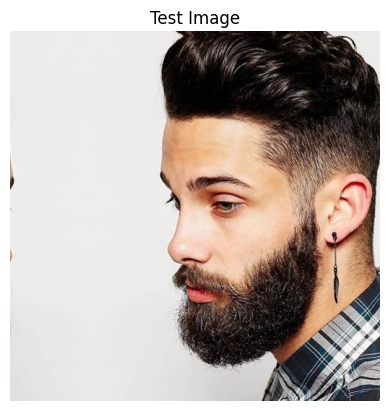


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Person is wearing earrings


In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST = "/content/face-attributes-grouped/face-attributes-grouped/test/accessories/earrings/40676442-7584-4054-89a7-eb2fe0236bc0_blog_ln_.jpg"

# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))


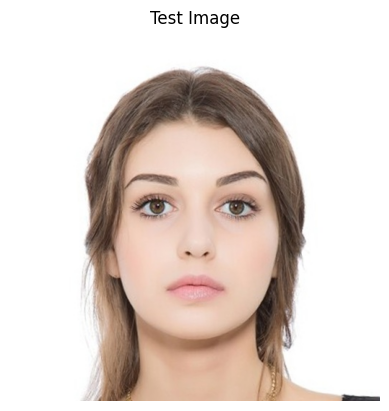


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Person is wearing necklace


In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST = "/content/face-attributes-grouped/face-attributes-grouped/test/accessories/necklace/2017-Fashion-Jewelry-Women-Necklaces-Pendants-3-multi-layer-Necklace-Tassel-Charm-Bar-statement-Necklace-for.jpg"

# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))


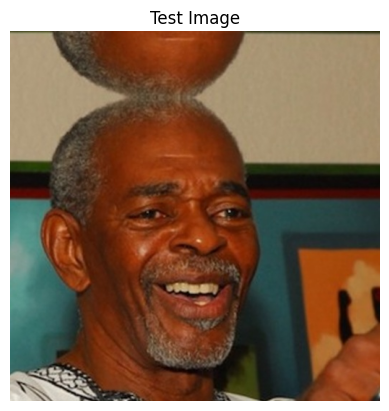


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Person is wearing no_accessories


In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST = "/content/face-attributes-grouped/face-attributes-grouped/test/accessories/no_accessories/artworks-000362257191-jf2dze-t500x500.jpg"

# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))


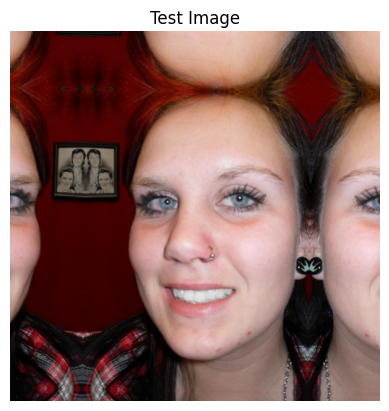


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Person is wearing piercings


In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST = "/content/face-attributes-grouped/face-attributes-grouped/test/accessories/piercings/nostril_piercing_by_sugarbritchestonja.jpg"

# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))
